In [25]:
import torch
import os
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
import math
from sklearn.metrics import mean_squared_error


In [2]:
inf = -10
sup = 10

segments_x = 100
segments_y = 200
step_x = (sup - inf)/segments_x
step_y = (sup - inf)/segments_y

data = np.zeros((segments_x*segments_y, 3))

In [3]:
for i in range(segments_x):
    for j in range(segments_y):
        data[i*segments_y + j][0] = inf+i*step_x
        data[i*segments_y + j][1] = inf+j*step_y
        data[i*segments_y + j][2] = math.sin(inf+i*step_x + 2*(inf+j*step_y))*math.exp(-(2*(inf+i*step_x) + (inf+j*step_y))**2)
        

In [4]:
data

array([[-10. , -10. ,   0. ],
       [-10. ,  -9.9,   0. ],
       [-10. ,  -9.8,   0. ],
       ...,
       [  9.8,   9.7,  -0. ],
       [  9.8,   9.8,  -0. ],
       [  9.8,   9.9,  -0. ]])

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[:, :2], 
                                                    data[:, 2], 
                                                    test_size=0.3, 
                                                    shuffle=True)

train_dataset = np.zeros((X_train.shape[0], 3))
train_dataset[:, :2] = X_train
train_dataset[:, 2] = y_train

test_dataset = np.zeros((X_test.shape[0], 3))
test_dataset[:, :2] = X_test
test_dataset[:, 2] = y_test

train_dataset = torch.from_numpy(train_dataset)
test_dataset = torch.from_numpy(test_dataset)

In [9]:
batch_size = 20

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [10]:
class FNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(FNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 1)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
f_net = FNet(10)

In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(f_net.parameters(), lr=1.0e-3)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
f_net = f_net.to(device)

In [22]:
epochs = 500
history = []

f_net.train(True)
for i in tqdm(range(epochs)):
    epoch_loss = []
    # Iterate over batches
    for batch in train_loader:
        optimizer.zero_grad() # Do not forget this!
        # Forward
        x = batch[:, :2].float().to(device)
        y = batch[:, 2].long().to(device)
        pred_y = f_net(x)

        # Compute loss
        loss = criterion(pred_y, y)
        epoch_loss.append(loss.item())

        # Backward: propagate gradients
        loss.backward()
        
        # Update
        optimizer.step()
    if i % 10 == 0:
      history.append(np.array(epoch_loss).mean())

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [19:31<00:00,  2.34s/it]


In [33]:
f_net.train(False)

test_preds = []
test_labels = []
for batch in test_loader:
    x = batch[:, :2].float().to(device)
    y = batch[:, 2].float()
      
    test_labels += list(y)
    test_preds += list(f_net.inference(x).detach().numpy())

In [34]:
print(mean_squared_error(test_labels, test_preds))

1.0173068


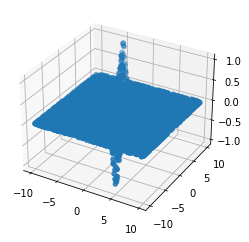

In [40]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs = test_dataset[:,0], ys = test_dataset[:,1], zs = test_dataset[:, 2])

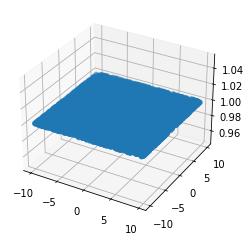

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs = test_dataset[:,0], ys = test_dataset[:,1], zs = test_preds)